In [22]:
 # --- 配置路径 (请根据你的实际文件名修改) ---
BAM_FILE = "/data/work/human_brain/710_68_1_humanbrain_251209_NB.duplicates.directional.bam"  # 68_1 UMI去重bam
GTF_FILE = "/data/work/human_brain/genes.gtf"
FASTA_FILE = "/data/work/human_brain/genome.fasta"
DB_FILE = "/data/work/hg38_annotations.db" # 运行后生成的数据库缓存

In [2]:
import gffutils
# 1. 先连接数据库文件，生成对象
db = gffutils.FeatureDB("/data/work/hg38_annotations.db")

In [6]:
import os
import pickle
import pysam
import pandas as pd
import gffutils
from intervaltree import IntervalTree

def get_gene_structure_dict(db, cache_path="gene_structure_cache.pkl"):
    """
    如果缓存文件存在则加载，否则构建并保存。
    """
    if os.path.exists(cache_path):
        print(f"--- 发现缓存文件，正在从 {cache_path} 加载基因结构 ---")
        with open(cache_path, 'rb') as f:
            return pickle.load(f)

    print("--- 未发现缓存，开始构建基因结构字典 (仅需运行一次) ---")
    gene_index = {}
    gene_structures = {} 
    
    # 获取总基因数用于进度展示（可选）
    total_genes = db.count_features_of_type('gene')
    count = 0
    
    for gene in db.features_of_type('gene'):
        chrom = gene.chrom
        strand = gene.strand
        g_id = gene.id
        g_name = gene.attributes.get('gene_name', [g_id])[0]
        
        if chrom not in gene_index:
            gene_index[chrom] = IntervalTree()
        
        gene_index[chrom].addi(gene.start, gene.end, g_id)
        
        last_exons = set()
        all_exons = set() 
        
        for tx in db.children(gene, featuretype='transcript'):
            exons = sorted(list(db.children(tx, featuretype='exon')), key=lambda e: e.start)
            if not exons: continue
            
            target_last = exons[-1] if strand == '+' else exons[0]
            last_exons.add((target_last.start, target_last.end))
            
            for e in exons:
                all_exons.add((e.start, e.end))
        
        gene_structures[g_id] = {
            'name': g_name,
            'strand': strand,
            'last_exons': last_exons,
            'all_exons': all_exons,
            'g_range': (gene.start, gene.end)
        }

       
        count += 1
        if count % 5000 == 0:
            print(f"已处理 {count}/{total_genes} 个基因...")

    # 保存到磁盘
    print(f"--- 正在保存缓存到 {cache_path} ---")
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_structures, f)
        
    return gene_structures

In [7]:
cache_file = get_gene_structure_dict(db, cache_path="gene_structure_cache.pkl")

--- 未发现缓存，开始构建基因结构字典 (仅需运行一次) ---
已处理 5000/36601 个基因...
已处理 10000/36601 个基因...
已处理 15000/36601 个基因...
已处理 20000/36601 个基因...
已处理 25000/36601 个基因...
已处理 30000/36601 个基因...
已处理 35000/36601 个基因...
--- 正在保存缓存到 gene_structure_cache.pkl ---


## 最后一个 M/=/X作为捕获位点

In [8]:
import pysam
import pandas as pd
import gffutils

def get_precise_capture_site(read, strand):
    """
    根据基因的正负链信息，解析 CIGAR 字符串以获取捕获位点：
    - 如果是正链基因 (+): 捕获位点在 Read 基因组坐标的最右端 (最后一个 M/=/X)
    - 如果是负链基因 (-): 捕获位点在 Read 基因组坐标的最左端 (第一个 M/=/X)
    """
    cigars = read.cigartuples
    if not cigars:
        return read.reference_start, 0

    if strand == '+':
        # 基因在正链：捕获位点是 Read 的末端
        curr_ref_pos = read.reference_start
        last_match_end = read.reference_start
        last_m_len = 0
        for op, length in cigars:
            # op: 0=M, 2=D, 3=N, 7==, 8=X (这些操作消耗参考基因组长度)
            if op in (0, 2, 7, 8):
                curr_ref_pos += length
                if op != 2: # 只有匹配块才是有效的捕获末端
                    last_match_end = curr_ref_pos
                    last_m_len = length
            elif op == 3: # N 跨越内含子
                curr_ref_pos += length
        return last_match_end, last_m_len

    else:
        # 基因在负链：捕获位点是 Read 的起始端
        curr_ref_pos = read.reference_start
        for op, length in cigars:
            if op in (0, 7, 8): # 找到第一个匹配块
                return curr_ref_pos, length
            if op in (2, 3): # D, N 消耗坐标
                curr_ref_pos += length
        return read.reference_start, 0


In [17]:
def analyze_capture_with_cache(bam_path, db, cache_file="gene_structure_cache.pkl", wobble = 15):
    # 步骤 1: 获取基因字典 (带缓存)
    gene_structures = get_gene_structure_dict(db, cache_path=cache_file)

    # 步骤 2: 遍历 BAM (代码逻辑同)
    print("--- 步骤 2: 开始扫描 BAM 并提取坐标 ---")
    bf = pysam.AlignmentFile(bam_path, "rb")
    results_list = []
    counts = {"Last Exon": 0, "Internal Exon": 0, "Intron": 0, "Other": 0}
    total_primary = 0

    for read in bf.fetch(until_eof=True):
        # 过滤非主要比对
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        
        total_primary += 1
        
        # 检索该read所在的基因
        # →通过read的GX注释获取g.id
        try:
            gx_id = read.get_tag('GX')
        except KeyError:
            counts["Other"] += 1
            continue
        
        if gx_id not in gene_structures:
            counts["Other"] += 1
            continue
            
        struct = gene_structures[gx_id]
        strand = struct['strand']
        g_s, g_e = struct['g_range']
        
        # 1.使用之前定义的 CIGAR 解析函数
        capture_site, terminal_m_len = get_precise_capture_site(read, struct['strand'])# 从数据库获取的真实基因链方向
        
        # 2.计算相对位置 (同前)
        if (g_e - g_s) != 0:
            rel_pos = (capture_site - g_s) / (g_e - g_s) if strand == '+' else (g_e - capture_site) / (g_e - g_s)
        else:
            rel_pos = 0
        rel_pos = max(0, min(1, rel_pos))

        # 3.三级判定逻辑 (同前)
        location = "Intron"
        is_matched = False
        
        for s, e in struct['last_exons']:
            if (s - wobble) <= capture_site <= (e + wobble): # 外显子边界加了wobble区域
                location = "Last Exon"
                counts["Last Exon"] += 1
                is_matched = True
                break
        
        if not is_matched:
            for s, e in struct['all_exons']:
                if (s - wobble) <= capture_site <= (e + wobble): # 外显子边界加了wobble区域
                    location = "Internal Exon"
                    counts["Internal Exon"] += 1
                    is_matched = True
                    break
        
        if not is_matched:
            counts["Intron"] += 1
         
        # 记录详细信息
        results_list.append({
            'read_name': read.query_name,
            'gene_id': gx_id,
            'capture_site': capture_site,
            'location': location,
            'rel_pos': rel_pos
        })
        
        if total_primary % 500000 == 0:
            print(f"已处理 {total_primary} 条 Reads...")


    bf.close()
    
    # --- 步骤 3: 汇总报告 ---
    print("\n" + "="*40)
    print("捕获位点分布统计报告")
    print("-" * 40)
    valid_total = total_primary - counts["Other"]
    for category in ["Last Exon", "Internal Exon", "Intron"]:
        count = counts[category]
        percentage = (count / valid_total) * 100 if valid_total > 0 else 0
        print(f"{category:15s}: {count:10d} ({percentage:.2f}%)")
    print(f"{'Other/Intergenic':15s}: {counts['Other']:10d}")
    print("="*40)
    
    return pd.DataFrame(results_list)

In [18]:
df_results = analyze_capture_with_cache(BAM_FILE, db, cache_file="gene_structure_cache.pkl", wobble = 15)

--- 发现缓存文件，正在从 gene_structure_cache.pkl 加载基因结构 ---
--- 步骤 2: 开始扫描 BAM 并提取坐标 ---
已处理 500000 条 Reads...
已处理 1000000 条 Reads...
已处理 1500000 条 Reads...
已处理 2000000 条 Reads...
已处理 2500000 条 Reads...
已处理 3000000 条 Reads...
已处理 3500000 条 Reads...
已处理 4000000 条 Reads...
已处理 4500000 条 Reads...
已处理 5000000 条 Reads...
已处理 5500000 条 Reads...
已处理 6000000 条 Reads...
已处理 7000000 条 Reads...
已处理 7500000 条 Reads...

捕获位点分布统计报告
----------------------------------------
Last Exon      :    2034067 (27.87%)
Internal Exon  :     363369 (4.98%)
Intron         :    4901616 (67.15%)
Other/Intergenic:     363092


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_capture_relative_distribution(df):
    """
    df 必须包含: 
    - rel_pos: 基于最长基因范围计算的 0-1 位置
    - location: 上一步统计出的 'Last Exon', 'Internal Exon', 'Intron'
    """
    
    print("--- 正在生成捕获位点相对位置分布图 ---")
    
    # 设置绘图风格
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 7))
    
    # 1. 准备数据
    # 正常捕获：Last Exon
    normal_reads = df[df['location'] == "Last Exon"]['rel_pos']
    # Internal Priming：Intron
    ip_reads = df[df['location'] == "Intron"]['rel_pos']
    
    # 2. 绘制密度曲线 (KDE)
    # 绿色代表正常捕获
    sns.kdeplot(normal_reads, bw_adjust=0.5, label=f"Normal Capture (n={len(normal_reads)})", 
                color="green", fill=True, alpha=0.3)
    
    # 红色代表内含子内部捕获
    sns.kdeplot(ip_reads, bw_adjust=0.5, label=f"Internal Priming (n={len(ip_reads)})", 
                color="red", fill=True, alpha=0.3)
    
    # 3. 修饰图表
    plt.title("Relative Position of Capture Sites on Gene Body (Longest Ref)", fontsize=15)
    plt.xlabel("Relative Position (0 = 5' End, 1 = 3' End)", fontsize=12)
    plt.ylabel("Density of Capture Events", fontsize=12)
    plt.xlim(-0.05, 1.05)
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    plt.legend(loc="upper left")
    
    # 添加一个注释说明
    plt.text(0.1, plt.gca().get_ylim()[1]*0.8, 
             "Red: Intronic Capture\nGreen: Last Exon Capture", 
             bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

# --- 补充逻辑：如何计算基于最长转录本的 rel_pos ---
# 在你明天的脚本循环中，可以加入以下逻辑：
# 1. 找到该基因所有转录本中 start 最小、end 最大的范围作为 "Full Gene Length"
# 2. rel_pos = abs(capture_site - 5_prime_end) / full_gene_length

--- 正在生成捕获位点相对位置分布图 ---


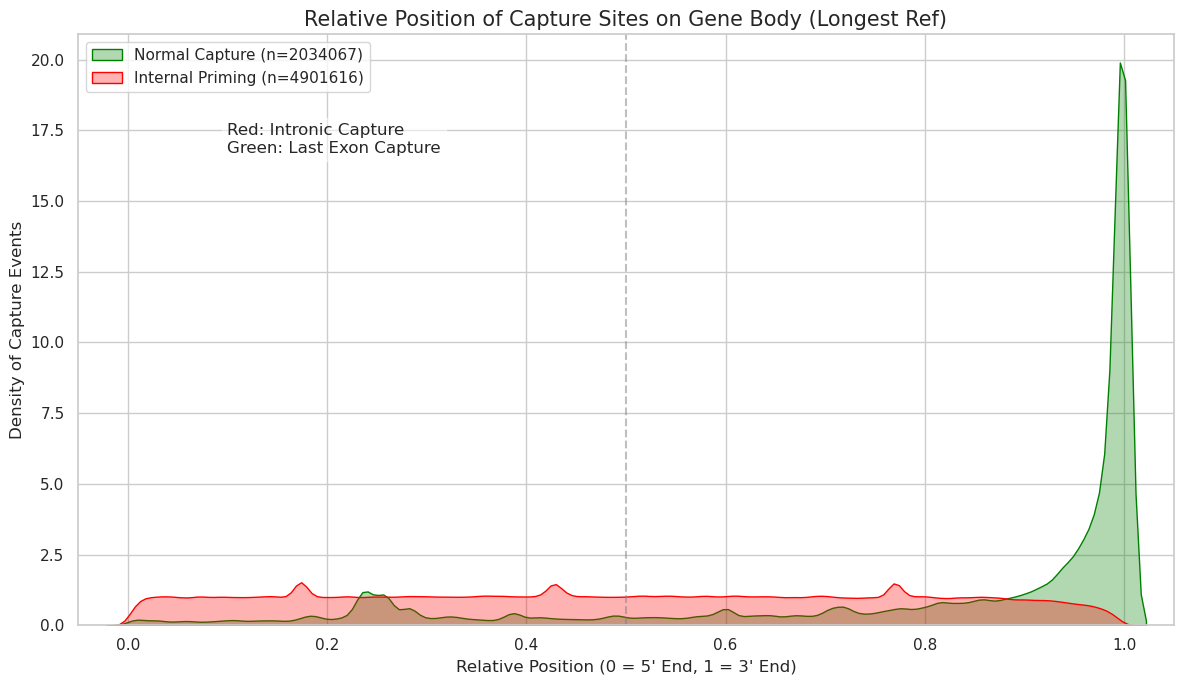

In [20]:
plot_capture_relative_distribution(df_results)

## 用read自己的转录本比对注释，画这个图试试？

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_and_extract_target_ip(df, near_3p_threshold=0, target_threshold= 0):
    """
    1. 绘制 IP 分布图
    2. 筛选并返回 RelPos < 0.99 的目标 Reads DataFrame，用于后续 CIGAR 解析
    """
    # --- 1. 数据筛选 ---
    # 仅保留内含子捕获
    ip_df = df[df['location'] == "Intron"].copy()
    
    # 提取你的目标子集 (RelPos < 0.99)
    # 这个 target_df 就是你要拿去跑 CIGAR 解析的数据
    target_df = ip_df[ip_df['rel_pos'] > target_threshold].copy()
    
    total_ip = len(ip_df)
    target_count = len(target_df)
    
    if total_ip == 0:
        print("错误: 未发现任何 Intron 捕获记录。")
        return None

    # --- 2. 统计打印 (修正了变量名引用) ---
    near_3p_df = ip_df[ip_df['rel_pos'] >= near_3p_threshold]
    near_3p_count = len(near_3p_df)
    # 修正：原代码中 total_ip_count 未定义，应为 total_ip
    near_3p_ratio = (near_3p_count / total_ip) * 100

    print(f"--- 统计结果 ---")
    print(f"Internal Priming (Intron) 总数: {total_ip}")
    print(f"靠近 3' 端 (RelPos >= {near_3p_threshold}) 的数量: {near_3p_count}")
    print(f"在 IP 中的占比: {near_3p_ratio:.2f}%")
    print(f"已提取目标子集 (RelPos > {target_threshold}) 数量: {target_count}")

    # --- 3. 绘图部分 ---
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # 绘制整体 IP 分布 (Counts)
    ax = sns.histplot(ip_df['rel_pos'], bins=100, kde=True, color="red", alpha=0.4, edgecolor=None)

    # 修饰图表
    plt.title(f"Genomic Distribution of Internal Priming (n={total_ip})", fontsize=14)
    plt.xlabel("Relative Position (0 = 5' End, 1 = 3' End)", fontsize=12)
    plt.ylabel("Read Counts", fontsize=12)
    plt.xlim(0, 1.05) # 稍微放宽一点边界，能看到 1.0 处的柱子

    # 绘制阈值线
    plt.axvline(x=near_3p_threshold, color='darkred', linestyle='--')
    
    # 标注文本 (修正了坐标偏移和文本内容)
    plt.text(near_3p_threshold - 0.15, ax.get_ylim()[1] * 0.7, 
             f"Near 3' Zone\n({near_3p_ratio:.2f}%)", 
             color='darkred', weight='bold', bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

    # --- 4. 返回目标子集 ---
    # 这里的 target_df 携带了所有的原始信息（read_id, chrom, start, end 等）
    return target_df

--- 统计结果 ---
Internal Priming (Intron) 总数: 4901616
靠近 3' 端 (RelPos >= 0) 的数量: 4901616
在 IP 中的占比: 100.00%
已提取目标子集 (RelPos > 0) 数量: 4901616


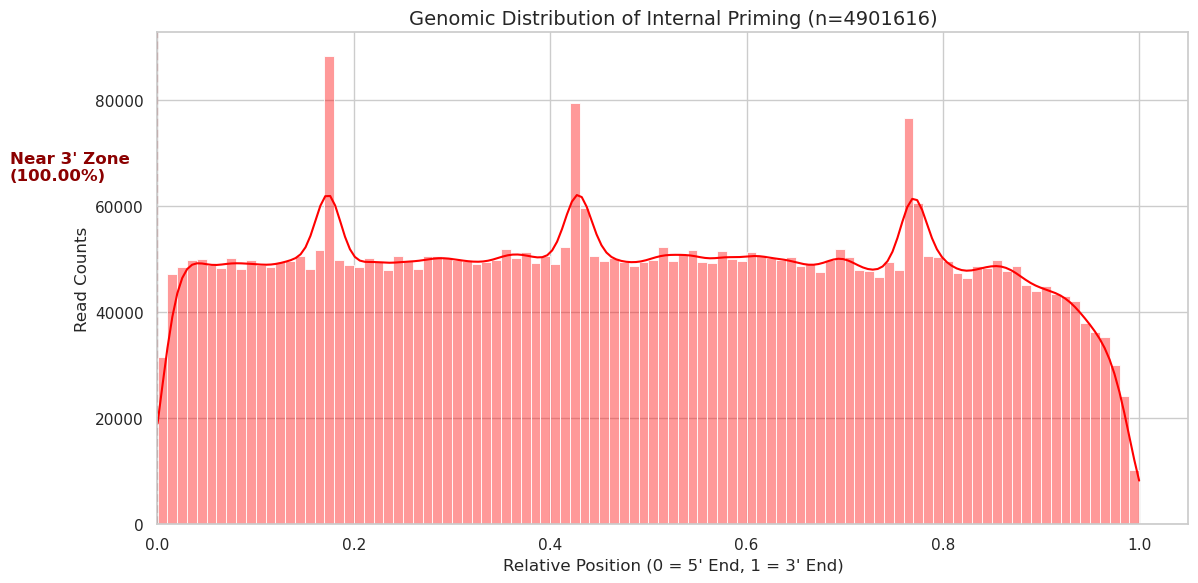

In [26]:
df_target_23w = plot_and_extract_target_ip(df_results)

In [27]:
import pysam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from intervaltree import IntervalTree

def analyze_target_n_and_overlap(bam_path, db, target_df):
    """
    针对 RelPos > 0.99 的目标 Reads (使用 read_name 列):
    1. 统计含有 N (剪接信号) 的比例
    2. 计算在当前内含子内的连续比对长度
    """
    # 1. 获取目标 ID 集合
    if 'read_name' not in target_df.columns:
        print("错误: 提供的 DataFrame 中找不到 'read_name' 列。")
        return None
        
    target_qnames = set(target_df['read_name'])
    print(f"--- 成功加载 {len(target_qnames)} 条目标 Reads ---")

    # 2. 【核心修复步】构建内含子索引
    # 确保 intron_index 在此处被正确初始化
    print("--- 步骤 1: 构建基因组内含子索引 ---")
    intron_index = {}
    
    # 遍历数据库构建区间树
    for gene in db.features_of_type('gene'):
        chrom, strand = gene.chrom, gene.strand
        # 获取该基因所有外显子
        exons = sorted(list(db.children(gene, featuretype='exon')), key=lambda e: e.start)
        if len(exons) < 2: 
            continue
            
        if chrom not in intron_index:
            intron_index[chrom] = IntervalTree()
            
        # 计算外显子之间的间隙作为内含子
        for i in range(len(exons) - 1):
            i_start, i_end = exons[i].end + 1, exons[i+1].start - 1
            if i_end > i_start:
                # 存储内含子边界和链信息
                intron_index[chrom].addi(i_start, i_end, (i_start, i_end, strand))

    # 3. 扫描 BAM 文件
    bf = pysam.AlignmentFile(bam_path, "rb")
    results = []
    n_count = 0
    total_processed = 0

    print("--- 步骤 2: 正在扫描 BAM 文件提取 CIGAR 信息 ---")
    for read in bf:
        # 过滤非 primary reads
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
            
        # 仅处理目标集合中的 Read
        if read.query_name in target_qnames:
            total_processed += 1
            
            # 统计 N 比例
            has_n = True if (read.cigarstring and 'N' in read.cigarstring) else False
            if has_n: n_count += 1
            
            # 计算连续内含子长度
            chrom = read.reference_name
            # 判定 3' 捕获端
            capture_site = read.reference_end if not read.is_reverse else read.reference_start
            
            # 安全检查索引是否存在该染色体
            if chrom in intron_index:
                matches = intron_index[chrom].at(capture_site)
                if matches:
                    for m in matches:
                        i_start, i_end, _ = m.data
                        # 解析 CIGAR 序列
                        ops = read.cigartuples[::-1] if not read.is_reverse else read.cigartuples
                        
                        contiguous_len = 0
                        for op, length in ops:
                            if op in (0, 2, 7, 8): # M, D, =, X
                                contiguous_len += length
                            elif op == 3: # N (遇到了剪接跳跃)
                                break
                            elif op == 4: # S (忽略 Soft clip)
                                continue
                            
                            # 边界检查
                            curr_pos = capture_site - contiguous_len if not read.is_reverse else capture_site + contiguous_len
                            if not (i_start <= curr_pos <= i_end):
                                contiguous_len -= abs(curr_pos - (i_start if not read.is_reverse else i_end))
                                break
                        
                        results.append({'read_name': read.query_name, 'overlap': max(0, contiguous_len), 'has_n': has_n})
                        break # 一个 read 匹配到一个内含子即可

    bf.close()

    # 4. 输出统计数据
    if total_processed > 0:
        n_ratio = (n_count / total_processed) * 100
        print("\n" + "="*45)
        print(f"目标子集 (RelPos > 0.99) 最终统计报告")
        print("-" * 45)
        print(f"匹配到的目标 Reads 总数 : {total_processed}")
        print(f"含有 N (已剪接)         : {n_count}")
        print(f"不含 N (完全连续)       : {total_processed - n_count}")
        print(f"N 占比 (Spliced Ratio)  : {n_ratio:.2f}%")
        print("="*45)
    else:
        print("警告: 未能在 BAM 中匹配到任何 Read，请核对 ID 格式。")

    return pd.DataFrame(results)

In [29]:
df_final_stats = analyze_target_n_and_overlap(BAM_FILE, db, df_target_23w)

--- 成功加载 4901616 条目标 Reads ---
--- 步骤 1: 构建基因组内含子索引 ---
--- 步骤 2: 正在扫描 BAM 文件提取 CIGAR 信息 ---

目标子集 (RelPos > 0.99) 最终统计报告
---------------------------------------------
匹配到的目标 Reads 总数 : 4901616
含有 N (已剪接)         : 874536
不含 N (完全连续)       : 4027080
N 占比 (Spliced Ratio)  : 17.84%


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_target_overlap_with_stats_clear(df):
    plt.figure(figsize=(12, 7))
    
    # 1. 设置更清晰的配色
    color_map = {True: "#27AE60", False: "#F39C12"}  # 绿色 vs 橙色
    
    # 2. 计算合适的bin宽度
    # 根据数据范围和想要的清晰度调整
    bin_width = 20  # 每个bin 20bp，可以根据需要调整
    bins = int(3000 / bin_width)  # 0-3000范围，150个bins
    
    # 3. 绘制更清晰的直方图
    ax = sns.histplot(
        data=df, 
        x='overlap', 
        hue='has_n', 
        bins=bins,
        palette=color_map,
        alpha=0.7,          # 稍微增加透明度
        edgecolor='white',  # 添加白色边框
        linewidth=0.5,      # 边框线宽
        kde=False,          # 先不显示KDE，让柱状图更清晰
        stat='count',       # 显示计数
        common_norm=False   # 每组独立
    )
    
    # 4. 设置坐标轴和标题
    plt.xlim(0, 3000)
    plt.title("Contiguous Alignment Length within the Current Intron", 
              fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Contiguous Length in Intron (bp)", fontsize=13)
    plt.ylabel("Counts (Number of Reads)", fontsize=13)
    
    # 5. 计算统计值
    spliced_data = df[df['has_n'] == True]['overlap']
    unspliced_data = df[df['has_n'] == False]['overlap']
    
    stats = {
        'spliced': {
            'median': spliced_data.median(),
            'mean': spliced_data.mean(),
            'count': len(spliced_data)
        },
        'unspliced': {
            'median': unspliced_data.median(),
            'mean': unspliced_data.mean(),
            'count': len(unspliced_data)
        }
    }
    
    # 6. 添加清晰的统计线
    # Spliced组 - 深绿色
    plt.axvline(stats['spliced']['median'], 
                color='darkgreen', 
                linestyle='--', 
                linewidth=2.5,
                label=f'Spliced Median: {stats["spliced"]["median"]:.0f} bp')
    
    # Unspliced组 - 深橙色
    plt.axvline(stats['unspliced']['median'], 
                color='darkorange', 
                linestyle='--', 
                linewidth=2.5,
                label=f'Unspliced Median: {stats["unspliced"]["median"]:.0f} bp')

    
    # 8. 添加统计信息文本框
    stats_text = (
        f"Spliced Reads: {stats['spliced']['count']:,}\n"
        f"  Median: {stats['spliced']['median']:.0f} bp\n"
        f"  Mean: {stats['spliced']['mean']:.0f} bp\n\n"
        f"Unspliced Reads: {stats['unspliced']['count']:,}\n"
        f"  Median: {stats['unspliced']['median']:.0f} bp\n"
        f"  Mean: {stats['unspliced']['mean']:.0f} bp"
    )
    
    plt.text(
        0.98, 0.98, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8),
        fontsize=10,
        fontfamily='monospace'
    )
    
    # 9. 优化图例
    from matplotlib.patches import Patch
    
    # 创建自定义图例元素
    legend_elements = [
        Patch(facecolor='#27AE60', alpha=0.7, label='spliced reads'),
        Patch(facecolor='#F39C12', alpha=0.7, label='consecutive reads'),
    ]
    
    plt.legend(
        handles=legend_elements,
        title="Read Groups",
        loc='upper left',
        fontsize=10,
        title_fontsize=11
    )
    
    # 10. 网格和样式
    plt.grid(axis='y', alpha=0.3, linestyle=':')
    plt.grid(axis='x', alpha=0.2, linestyle=':')
    
    plt.tight_layout()
    plt.show()
    
    return stats

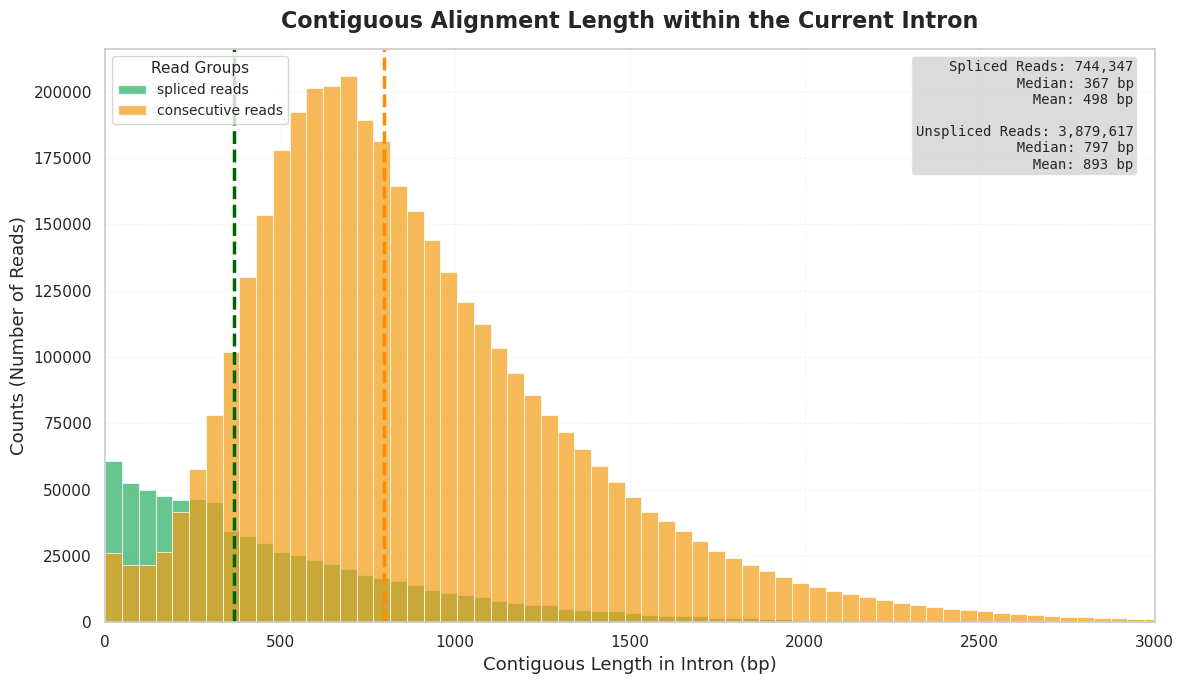

{'spliced': {'median': 367.0,
  'mean': np.float64(498.2308627562145),
  'count': 744347},
 'unspliced': {'median': 797.0,
  'mean': np.float64(893.0073589738369),
  'count': 3879617}}

In [33]:
plot_target_overlap_with_stats_clear(df_final_stats)

## 旧版-捕获位点read.reference_start/end 和CIGAR解析逻辑一致，结果一致

In [8]:
def analyze_capture_by_tag(bam_path, db):
    # --- 步骤 1: 建立 ID 映射字典 (极速) ---
    print("--- 步骤 1: 构建基因结构字典 ---")
    gene_structures = {}
    for gene in db.features_of_type('gene'):
        g_id = gene.id  # 确保这里的 ID 能匹配上 ENSG00000241599 这种格式
        
        # 提取该基因所有的末端外显子和全部外显子
        last_exons = set()
        all_exons = set()
        for tx in db.children(gene, featuretype='transcript'):
            exons = sorted(list(db.children(tx, featuretype='exon')), key=lambda e: e.start)
            if not exons: continue
            target_last = exons[-1] if gene.strand == '+' else exons[0]
            last_exons.add((target_last.start, target_last.end))
            for e in exons:
                all_exons.add((e.start, e.end))
        
        gene_structures[g_id] = {
            'strand': gene.strand,
            'last_exons': last_exons,
            'all_exons': all_exons,
            'g_range': (gene.start, gene.end)
        }

    # --- 步骤 2: 遍历 BAM，直接通过 GX 标签获取结构 ---
    print("--- 步骤 2: 开始扫描 BAM 并提取坐标 ---")
    bf = pysam.AlignmentFile(bam_path, "rb")
    results_list = []
    counts = {"Last Exon": 0, "Internal Exon": 0, "Intron": 0, "Other": 0}

    
    total_primary = 0
    
    for read in bf.fetch(until_eof=True):
        
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        total_primary += 1
        
        # 直接获取 Gene ID <--- 新增: 用bam文件中的基因注释
        try:
            gx_id = read.get_tag('GX')
        except KeyError:
            counts["Other"] += 1
            continue
        
        # 如果数据库里没有这个基因，跳过
        if gx_id not in gene_structures:
            counts["Other"] += 1
            continue
            
        struct = gene_structures[gx_id]
        
        # 1. 根据链的方向定义捕获位点 (Capture Site)
        r_start = read.reference_start
        r_end = read.reference_end
        strand = struct['strand'] # 从数据库获取该基因的正负链
        capture_site = r_end if strand == '+' else r_start
    

        # 2. 三级判定逻辑 (判定捕获点落在什么位置)
        location = "Intron" 
        is_matched = False
        
        for s, e in struct['last_exons']:
            if s <= capture_site <= e:
                location = "Last Exon"
                counts["Last Exon"] += 1
                is_matched = True
                break
        
        if not is_matched:
            for s, e in struct['all_exons']:
                if s <= capture_site <= e:
                    location = "Internal Exon"
                    counts["Internal Exon"] += 1
                    is_matched = True
                    break
        
        if not is_matched:
            counts["Intron"] += 1

    # 记录详细信息供后续分析
        results_list.append({
            'read_name': read.query_name,
            'gene_id': gx_id,
            'read_start': r_start,            # 用于定位
            'read_end': r_end,                # <--- 新增：全长 Read 的终止坐标
            'location': location              # 所在区域分类
        })

        if total_primary % 500000 == 0:
            print(f"已处理 {total_primary} 条 Reads...")

    bf.close()
   # --- 步骤 3: 汇总报告 ---
    print("\n" + "="*40)
    print("捕获位点分布统计报告")
    print("-" * 40)
    valid_total = total_primary - counts["Other"]
    for category in ["Last Exon", "Internal Exon", "Intron"]:
        count = counts[category]
        percentage = (count / valid_total) * 100 if valid_total > 0 else 0
        print(f"{category:15s}: {count:10d} ({percentage:.2f}%)")
    print(f"{'Other/Intergenic':15s}: {counts['Other']:10d}")
    print("="*40)
   
    return pd.DataFrame(results_list)

In [9]:
df_results_v2 = analyze_capture_by_tag(BAM_FILE, db)

--- 步骤 1: 构建基因结构字典 ---
--- 步骤 2: 开始扫描 BAM 并提取坐标 ---
已处理 500000 条 Reads...
已处理 1000000 条 Reads...
已处理 1500000 条 Reads...
已处理 2000000 条 Reads...
已处理 2500000 条 Reads...
已处理 3000000 条 Reads...
已处理 3500000 条 Reads...
已处理 4000000 条 Reads...
已处理 4500000 条 Reads...
已处理 5000000 条 Reads...
已处理 5500000 条 Reads...
已处理 6000000 条 Reads...
已处理 7000000 条 Reads...
已处理 7500000 条 Reads...

捕获位点分布统计报告
----------------------------------------
Last Exon      :    1910302 (26.17%)
Internal Exon  :     349480 (4.79%)
Intron         :    5039270 (69.04%)
Other/Intergenic:     363092


## 新版-CIGAR解析

In [10]:
import pysam
import pandas as pd
import gffutils

def get_precise_capture_site(read, strand):
    """
    根据基因的正负链信息，解析 CIGAR 字符串以获取捕获位点：
    - 如果是正链基因 (+): 捕获位点在 Read 基因组坐标的最右端 (最后一个 M/=/X)
    - 如果是负链基因 (-): 捕获位点在 Read 基因组坐标的最左端 (第一个 M/=/X)
    """
    cigars = read.cigartuples
    if not cigars:
        return read.reference_start, 0

    if strand == '+':
        # 基因在正链：捕获位点是 Read 的末端 (3' 端的基因组投影)
        curr_ref_pos = read.reference_start
        last_match_end = read.reference_start
        last_m_len = 0
        for op, length in cigars:
            # op: 0=M, 2=D, 3=N, 7==, 8=X (这些操作会消耗参考基因组长度)
            if op in (0, 2, 7, 8):
                curr_ref_pos += length
                if op != 2: # 只有匹配块才是有效的捕获末端
                    last_match_end = curr_ref_pos
                    last_m_len = length
            elif op == 3: # N 跨越内含子
                curr_ref_pos += length
        return last_match_end, last_m_len

    else:
        # 基因在负链：捕获位点是 Read 的起始端 (3' 端的基因组投影)
        # 注意：在负链基因中，转录是从右向左的，所以 Read 的起始坐标其实更接近 3' 末端
        curr_ref_pos = read.reference_start
        for op, length in cigars:
            if op in (0, 7, 8): # 找到第一个匹配块
                return curr_ref_pos, length
            if op in (2, 3): # D, N 消耗坐标
                curr_ref_pos += length
        return read.reference_start, 0


In [11]:
def analyze_capture_by_tag(bam_path, db):
    # --- 步骤 1: 构建基因结构字典 ---
    print("--- 步骤 1: 构建基因结构字典 ---")
    gene_structures = {}
    for gene in db.features_of_type('gene'):
        g_id = gene.id  
        
        last_exons = set()
        all_exons = set()
        for tx in db.children(gene, featuretype='transcript'):
            exons = sorted(list(db.children(tx, featuretype='exon')), key=lambda e: e.start)
            if not exons: continue
            # 根据基因链方向确定末端外显子
            target_last = exons[-1] if gene.strand == '+' else exons[0]
            last_exons.add((target_last.start, target_last.end))
            for e in exons:
                all_exons.add((e.start, e.end))
        
        gene_structures[g_id] = {
            'strand': gene.strand,
            'last_exons': list(last_exons),
            'all_exons': list(all_exons),
            'g_range': (gene.start, gene.end)
        }

    # --- 步骤 2: 遍历 BAM ---
    print("--- 步骤 2: 开始扫描 BAM 并提取坐标 ---")
    bf = pysam.AlignmentFile(bam_path, "rb")
    results_list = []
    counts = {"Last Exon": 0, "Internal Exon": 0, "Intron": 0, "Other": 0}
    total_primary = 0
    
    for read in bf.fetch(until_eof=True):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        
        total_primary += 1
        
        # 1. 获取 GX 标签并检索基因链方向
        try:
            gx_id = read.get_tag('GX')
        except KeyError:
            counts["Other"] += 1
            continue
        
        if gx_id not in gene_structures:
            counts["Other"] += 1
            continue
            
        struct = gene_structures[gx_id]
        gene_strand = struct['strand'] # 从数据库获取的真实基因链方向
        
        # 2. 根据基因链方向解析 CIGAR 得到精确捕获位点
        capture_site, terminal_m_len = get_precise_capture_site(read, gene_strand)

        # 3. 三级判定逻辑
        location = "Intron" 
        is_matched = False
        
        # 判定是否落在末端外显子
        for s, e in struct['last_exons']:
            if s <= capture_site <= e:
                location = "Last Exon"
                counts["Last Exon"] += 1
                is_matched = True
                break
        
        # 如果不在末端外显子，判定是否在其他外显子
        if not is_matched:
            for s, e in struct['all_exons']:
                if s <= capture_site <= e:
                    location = "Internal Exon"
                    counts["Internal Exon"] += 1
                    is_matched = True
                    break
        
        if not is_matched:
            counts["Intron"] += 1

        # 记录详细信息
        results_list.append({
            'read_name': read.query_name,
            'gene_id': gx_id,
            'capture_site': capture_site,
            'location': location
        })

        if total_primary % 500000 == 0:
            print(f"已处理 {total_primary} 条 Reads...")

    bf.close()

    # --- 步骤 3: 汇总报告 ---
    print("\n" + "="*40)
    print("捕获位点分布统计报告")
    print("-" * 40)
    valid_total = total_primary - counts["Other"]
    for category in ["Last Exon", "Internal Exon", "Intron"]:
        count = counts[category]
        percentage = (count / valid_total) * 100 if valid_total > 0 else 0
        print(f"{category:15s}: {count:10d} ({percentage:.2f}%)")
    print(f"{'Other/Intergenic':15s}: {counts['Other']:10d}")
    print("="*40)
    
    return pd.DataFrame(results_list)

In [12]:
df_results_v3 = analyze_capture_by_tag(BAM_FILE, db)

--- 步骤 1: 构建基因结构字典 ---
--- 步骤 2: 开始扫描 BAM 并提取坐标 ---
已处理 500000 条 Reads...
已处理 1000000 条 Reads...
已处理 1500000 条 Reads...
已处理 2000000 条 Reads...
已处理 2500000 条 Reads...
已处理 3000000 条 Reads...
已处理 3500000 条 Reads...
已处理 4000000 条 Reads...
已处理 4500000 条 Reads...
已处理 5000000 条 Reads...
已处理 5500000 条 Reads...
已处理 6000000 条 Reads...
已处理 7000000 条 Reads...
已处理 7500000 条 Reads...

捕获位点分布统计报告
----------------------------------------
Last Exon      :    1910302 (26.17%)
Internal Exon  :     349480 (4.79%)
Intron         :    5039270 (69.04%)
Other/Intergenic:     363092
